In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

In [3]:
days_to_extract = 1000
days_to_forecast = 20

In [4]:
date_end = dt.date.today()
date_start = date_end - dt.timedelta(days_to_extract)

In [5]:
date_end, date_start

(datetime.date(2020, 11, 8), datetime.date(2018, 2, 12))

In [6]:
df = pdr.DataReader("AAPL", 'yahoo', date_start, date_end).reset_index()

In [7]:
df = df.loc[df['Date'].notnull()]

In [8]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-02-12,40.972500,39.377499,39.625000,40.677502,243278000.0,38.984966
1,2018-02-13,41.187500,40.412498,40.487499,41.084999,130196800.0,39.375507
2,2018-02-14,41.884998,40.720001,40.759998,41.842499,162579600.0,40.101486
3,2018-02-15,43.272499,42.250000,42.447498,43.247501,204588800.0,41.448032
4,2018-02-16,43.705002,42.942501,43.090000,43.107498,160704400.0,41.313858
...,...,...,...,...,...,...,...
686,2020-11-02,110.680000,107.320000,109.110001,108.769997,122866900.0,108.582664
687,2020-11-03,111.489998,108.730003,109.660004,110.440002,107624400.0,110.249794
688,2020-11-04,115.589996,112.349998,114.139999,114.949997,138235500.0,114.752022
689,2020-11-05,119.620003,116.870003,117.949997,119.029999,126387100.0,118.824997


In [9]:
df.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

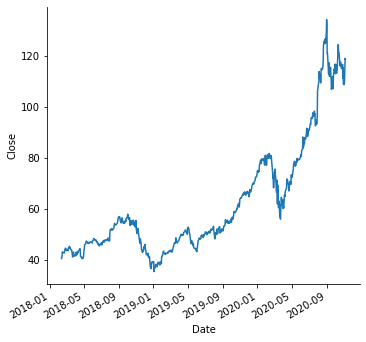

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df).fig.autofmt_xdate()

# preprocessing

In [11]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
le = preprocessing.LabelEncoder()

In [12]:
df['Date encoded'] = le.fit_transform(df['Date'])

In [13]:
days_cutoff = len(df) - days_to_forecast

In [14]:
scaled_Close = scaler.fit_transform(df[['Close']])

In [15]:
scaled_Close = np.squeeze(scaled_Close)

In [16]:
df.values[days_cutoff:, 7]

array([671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683,
       684, 685, 686, 687, 688, 689, 690], dtype=object)

In [17]:
x_train, y_train = df.values[:days_cutoff, 7], scaled_Close[:days_cutoff]
x_test, y_test = df.values[days_cutoff:, 7], scaled_Close[days_cutoff:]

x_train, y_train = df.values[:600, 0], scaled_Close[:600]
x_test, y_test = df.values[600:, 0], scaled_Close[600:]

In [18]:
x_train.shape, x_test.shape

((671,), (20,))

# split train data

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)


# Reshape data in order to apply LSTML

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((536,), (536,), (20,), (20,))

In [21]:

X_train_t = x_train.reshape(x_train.shape[0], 1, 1)
X_test_t = x_test.reshape(x_test.shape[0], 1, 1)

In [22]:
X_test_t.shape, X_train_t.shape

((20, 1, 1), (536, 1, 1))

## Keras

In [23]:
from keras.models import Sequential
from keras.layers import Dense

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import keras.backend as K 
from keras.callbacks import EarlyStopping
#import lstm, time

model = Sequential()

#model.add(Dense(50, activation='sigmoid', input_shape=(1,)))
#model.add(LSTM(30, activation='sigmoid', input_shape=(None,1)))
model.add(LSTM(30, activation='relu', input_shape=(None,1))) #rectified linear unit
model.add(Dense(1)) #, activation='linear'))

model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['mape']) 
#optimizer = 'adgrad', 'adam', 'sgd'
#sgd - stochastic gradient descent
#mse - mean square error
#mape - mean absolute percentage error

#history = model.fit(x_train, y_train, batch_size=10, epochs=200, validation_data=(x_valid, y_valid))

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)

history = model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________

Epoch 1/100
536/536 [==============================] - 0s 593us/step - loss: 109.7947 - mape: 8033377.5000
Epoch 2/100
536/536 [==============================] - 0s 55us/step - loss: 11.4476 - mape: 3804643.7500
Epoch 3/100
536/536 [==============================] - 0s 51us/step - loss: 3.2710 - mape: 1473725.8750
Epoch 4/100
536/536 [==============================] - 0s 56us/step - loss: 1.5973 - mape: 2506023.0000
Epoch 5/100
536/536 [==============================] - 0s 58us/step - loss: 1.1376 - mape: 25

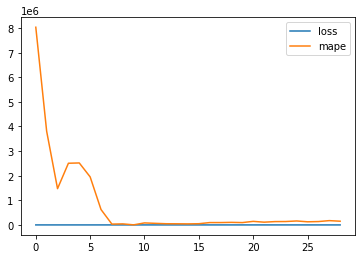

In [24]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [25]:
## evaluate model

#results = model.evaluate(x_test, y_test)

results = model.evaluate(X_test_t, y_test)
#print('Loss: {:.6f} - MAPE: {:.6f}'.format(*results))

20/20 [==============================] - 0s 2ms/step


trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

In [26]:
trainScore = model.evaluate(X_train_t, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(X_test_t, y_test, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(X_test_t, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  [0.013942833322642454, 96213.359375]
Validataion Score:  [0.04422696307301521, 24.629718780517578]
Test Score:  [0.04422696307301521, 24.629718780517578]


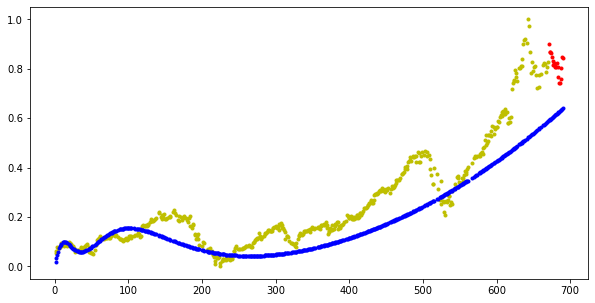

In [27]:
test_pred = model.predict(X_test_t)
train_pred = model.predict(X_train_t)
#train_pred = np.squeeze(train_pred)

plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, '.y', x_test, y_test, '.r',x_train, train_pred, '.b', x_test, test_pred, '.b')
plt.show()

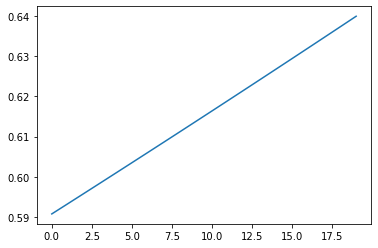

In [28]:
plt.figure()
plt.plot(test_pred)

for pred, true in zip(test_pred, y_test):
    print('Pred: {:.6f} - True: {:.6f}'.format(pred,true))

Save model

In [29]:
model_path = 'model.lstm_relu'
model.save(model_path)

from keras.models import load_model

loaded_model = load_model(model_path)

In [30]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
